In [319]:
import pandas as pd
import numpy as np
from utilities import *
from CrossValidation import *
from features import *
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [320]:
# Data
df_ohlcv = pd.read_csv('data/NQ/NQ_dollar_w250_b200.csv', index_col=0)
# df_ohlcv = pd.read_csv('data/NQ/NQ_dollar.csv', index_col=0)
df_ohlcv.Time0 = pd.to_datetime(df_ohlcv.Time0)#, unit='ms')
df_ohlcv.Time1 = pd.to_datetime(df_ohlcv.Time1)#, unit='ms')
df_ohlcv.set_index('Time0', inplace=True)
df_ohlcv['barID'] = df_ohlcv.reset_index().index.values
df_ohlcv = correct_duplicate_timeindex(df_ohlcv)

/Users/kennypark/Desktop/nonsibi_capital/Analysis/utilities.py:535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ohlcv['Time0'].iloc[idx+i]+= pd.Timedelta(microseconds=(i))
/Users/kennypark/Desktop/nonsibi_capital/Analysis/utilities.py:535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ohlcv['Time0'].iloc[idx+i]+= pd.Timedelta(microseconds=(i))
/Users/kennypark/Desktop/nonsibi_capital/Analysis/utilities.py:535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [267]:
trainStart, trainEnd = pd.to_datetime("2000-01-01"), pd.to_datetime("2019-12-30"); trainDays = (trainEnd - trainStart).days/365*250
testStart, testEnd = pd.to_datetime("2020-01-01"), pd.to_datetime("2024-03-01"); testDays = (testEnd - testStart).days/365*250

In [278]:
# Bollinger Sampling
lookback = 100
thres = -2
blgr = getBollinger(df_ohlcv.Close, lookback)

# Remove Overlaps
hp = 100
events = getCrossingEvents(blgr, df_ohlcv, thres, crossing='downward', mid = 0)
t1 = getVertBarrier(events.index, df_ohlcv.Close, numBars = hp)
events = pd.DataFrame(index = t1.index)
events['t1'] = t1.values
events = removeTimeOverlap(events)
events.shape

(6067, 1)

In [279]:
# Labeling
Y = pd.DataFrame(index = events.index)  
Y['ret'] = get_cont(df_ohlcv, events, method='lret')
Y['sharpe'] = get_cont(df_ohlcv, events, method='sharpe')
Y['slope'] = get_cont(df_ohlcv, events, method='slope')

In [280]:
print('avg prediction horizon:', round((events.t1 - events.index).dt.seconds.rolling(100).mean().mean()/60/60,2),'hours')

avg prediction horizon: 10.12 hours


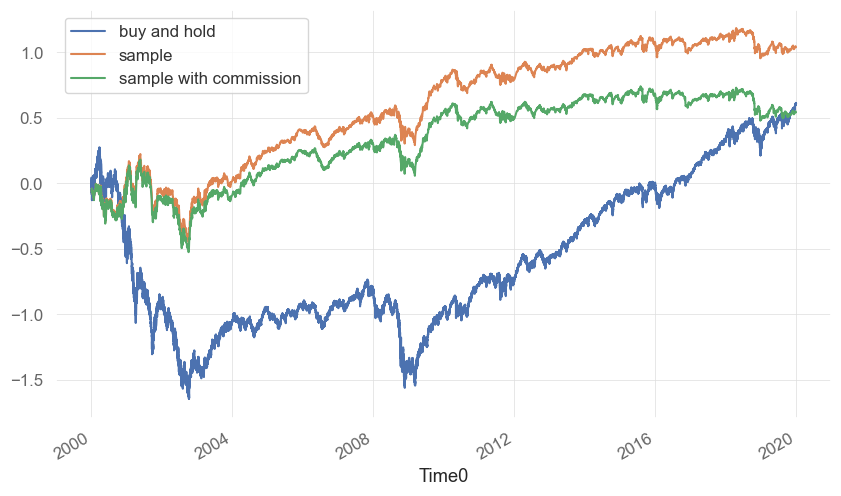

In [281]:
# Benchmark
np.log(df_ohlcv.Close).diff()[trainStart:trainEnd].cumsum().plot(label = 'buy and hold')
Y.ret[trainStart:trainEnd].cumsum().plot(label = 'sample')
(Y.ret[trainStart:trainEnd]-0.0001).cumsum().plot(label = 'sample with commission')
plt.legend()
plt.show()

                           Strategy
-------------------------  ----------
Start Period               2000-01-04
End Period                 2019-12-27
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          71.63%
CAGR﹪                     1.88%

Sharpe                     0.24
Prob. Sharpe Ratio         85.7%
Smart Sharpe               0.23
Sortino                    0.35
Smart Sortino              0.35
Sortino/√2                 0.25
Smart Sortino/√2           0.24
Omega                      1.05

Max Drawdown               -50.61%
Longest DD Days            1608
Volatility (ann.)          18.87%
Calmar                     0.04
Skew                       0.73
Kurtosis                   10.45

Expected Daily %           0.01%
Expected Monthly %         0.23%
Expected Yearly %          2.74%
Kelly Criterion            2.26%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.94%
Expected Shortfall (cVaR)  -1.94%

Max Consecutive Wins      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2001-05-22,2002-10-04,2005-05-25,1464,-50.611586,-48.314540
2,2001-01-24,2001-04-03,2001-05-08,104,-27.382017,-26.150754
3,2008-08-15,2009-03-06,2009-06-26,315,-26.826120,-25.107456
4,2000-02-18,2000-05-23,2000-12-22,309,-26.091992,-24.235725
5,2015-08-03,2018-12-24,2019-12-27,1608,-22.986858,-21.244815


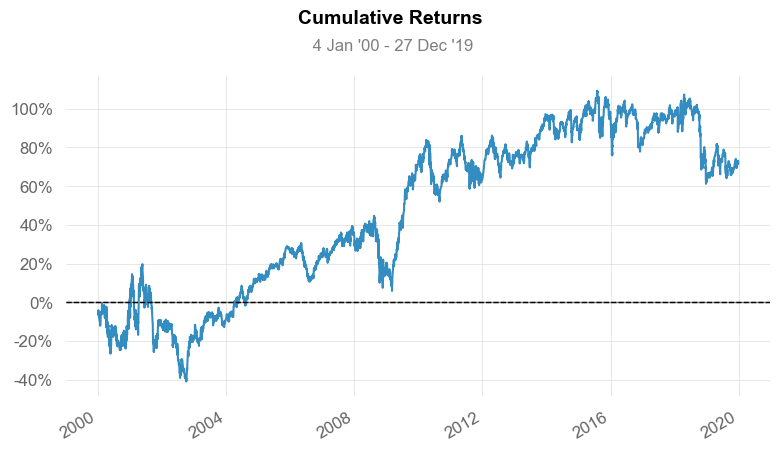

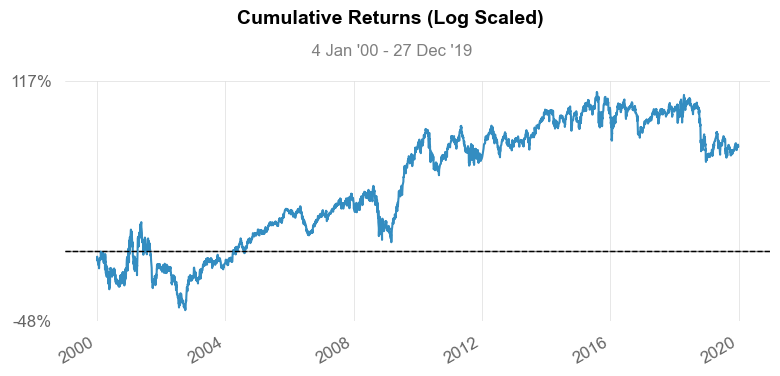

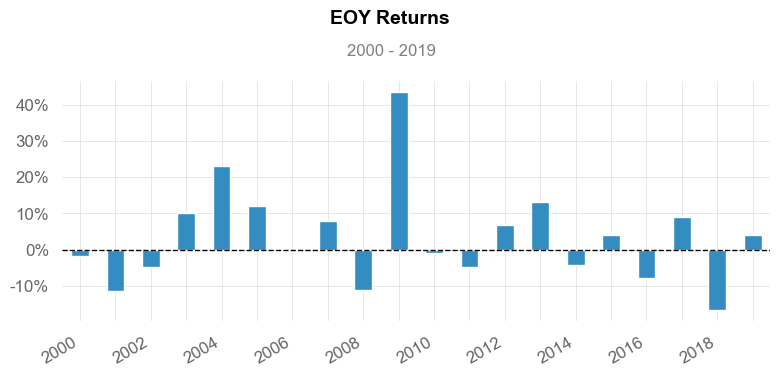

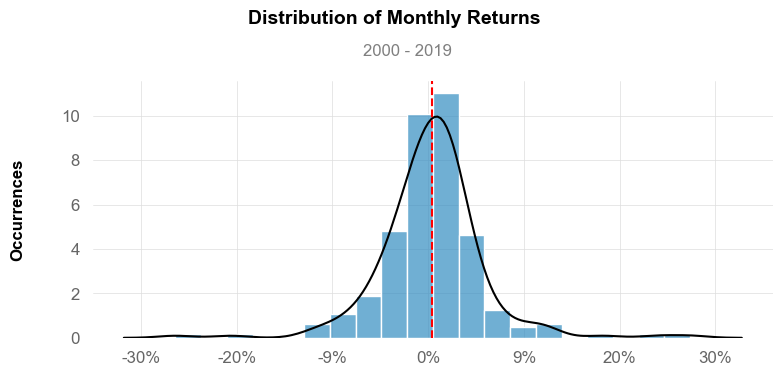

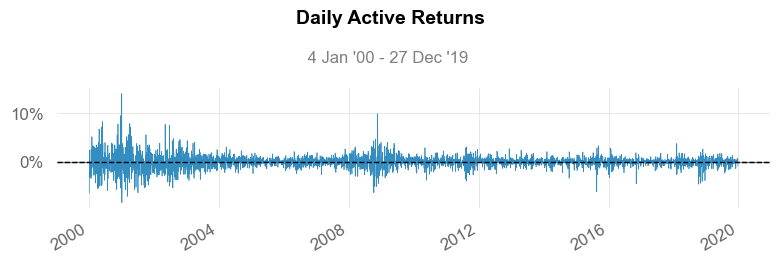

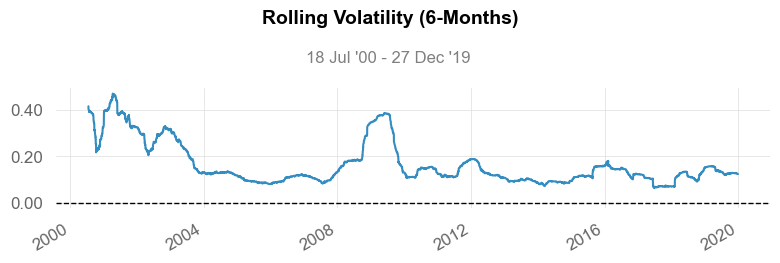

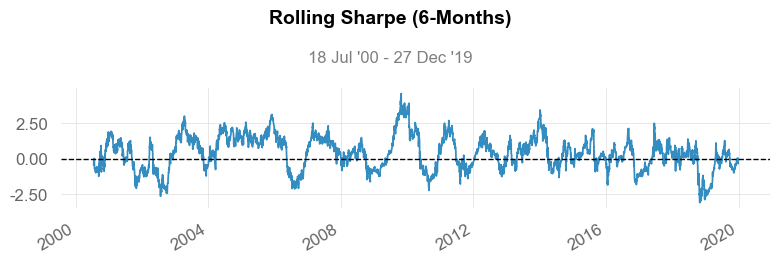

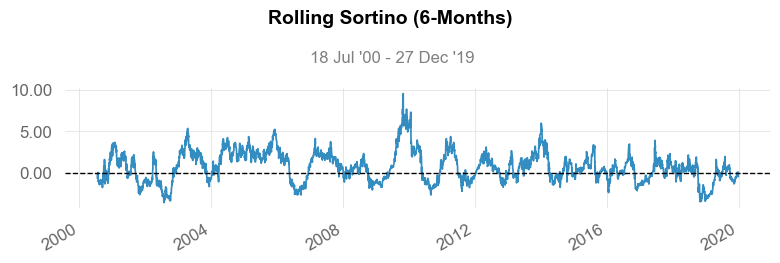

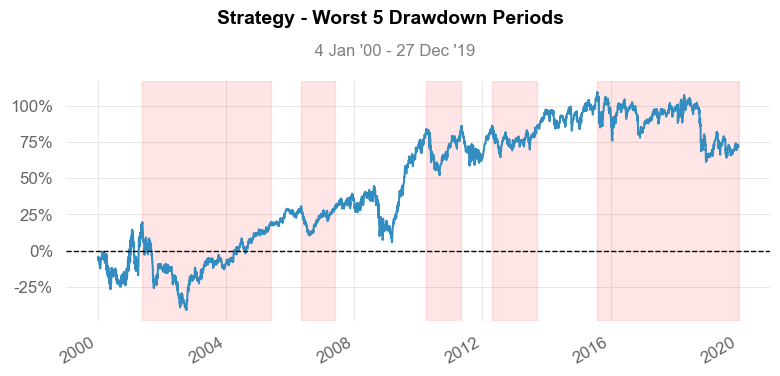

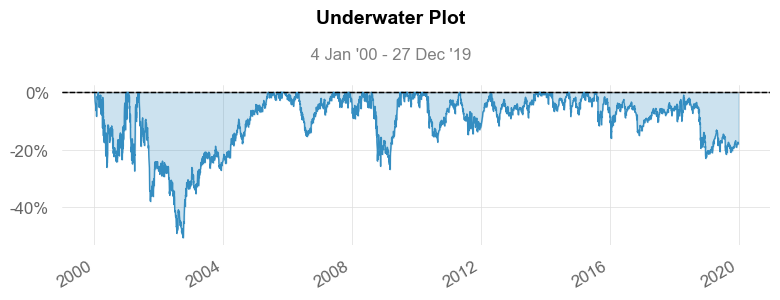

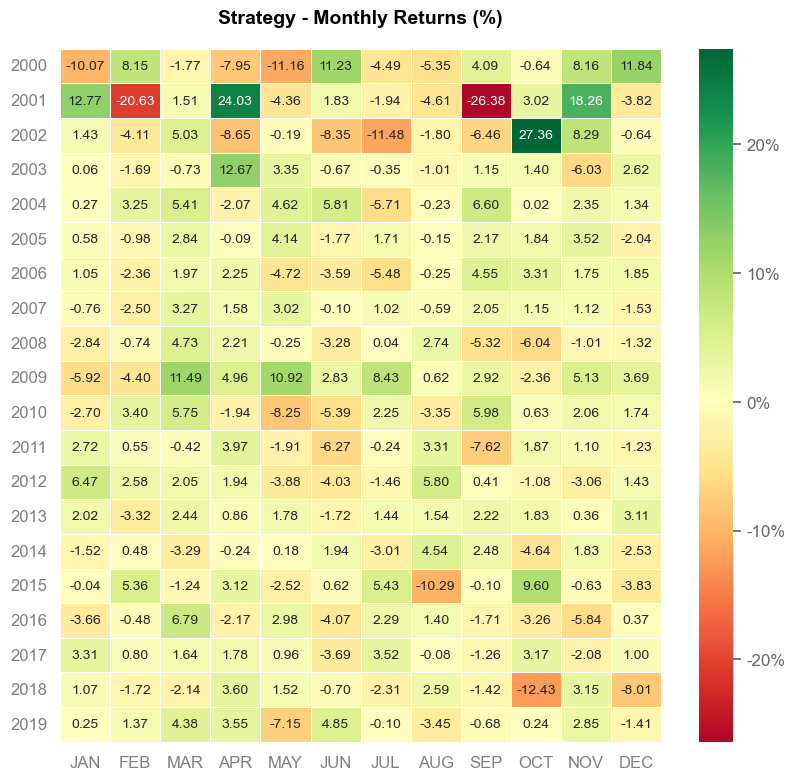

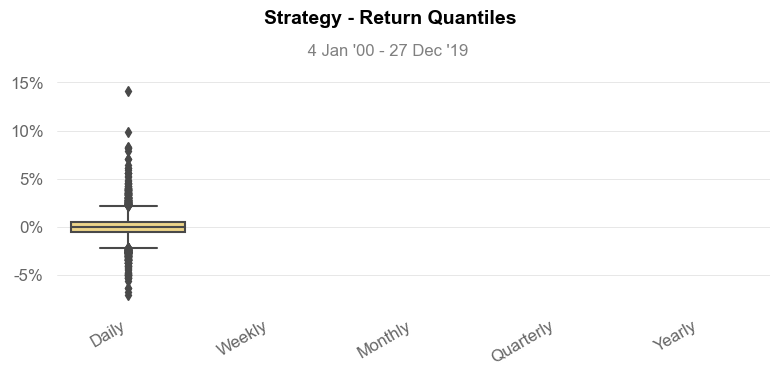

In [282]:
import quantstats as qs
qs.reports.full((np.exp(Y.ret[trainStart:trainEnd])-1-0.0001))

In [283]:
# Feature Library
# 13개
def add_featureSetA (X, tEvent, df, scale, lookback):
    print(f'Adding Feature Set A with lookback={lookback} and scale {scale}')
    close_path = getPathMatrix(df.Close, tEvent, nbars = lookback, scale = scale)
    lrets_path = np.log(close_path).diff(axis=1)
    
    X[f'sharpe1_{scale}'] = (lrets_path.sum(axis=1)/np.sqrt((lrets_path**2).sum(axis=1)))
    X[f'sharpe2_{scale}'] = (lrets_path.sum(axis=1)/lrets_path.std(axis=1))
    X[f'returns_{scale}'] = lrets_path.sum(axis=1)
    X[f'std_{scale}'] = lrets_path.std(axis=1)
    X[f'vol_{scale}'] = np.sqrt((lrets_path**2).sum(axis=1))

    X[f'blgr_{scale}'] = getBollinger(df.Close, lookback*scale)[tEvent]
    X[f'trend_{scale}'] = getTrend(tEvent, df.Close, lookback, scale = scale, use_log=True)
    X[f'trendblgr_{scale}'] = getTrendBlgr(tEvent, df.Close, lookback, scale = scale, use_log=True)
    X[f'willR_{scale}'] = williamsR(df.Close, lookback*scale, nFrac=10)[tEvent]

    X[f'ar1_{scale}'] = getAR1(tEvent, df.Close, lookback, scale=scale, use_log=True)
    X[f'adf_{scale}'] = getADF(tEvent, df.Close, lookback, scale=scale,  constant ='c', lags = int(lookback*0.1),)                      

    X[f'macd_norm1_{scale}'] = getMACD_norm(np.log(df.Close), span_short = scale*lookback//4, span_long = scale*lookback//2, use_ewm = False)[tEvent]
    X[f'macd_norm2_{scale}'] = getMACD_norm(np.log(df.Close), span_short = scale*lookback//2, span_long = scale*lookback, use_ewm = False)[tEvent]
    return X

# 총 30개
def add_featureSetB(X, tEvent, df, scale, lookback):
    print(f'Adding Feature Set B with lookback={lookback} and scale = {scale}')
    import ta
    lookback = lookback*scale
    
    # # Volume (2)
    # X[f'cmf_{scale}'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=lookback).chaikin_money_flow().loc[tEvent]
    # X[f'mfi_{scale}'] = ta.volume.MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=lookback).money_flow_index().loc[tEvent]

    # Volatility Indicators (6)
    X[f'bbw_{scale}'] = ta.volatility.BollingerBands(close=df['Close'], window=lookback).bollinger_wband().loc[tEvent]
    X[f'bbp_{scale}'] = ta.volatility.BollingerBands(close=df['Close'], window=lookback).bollinger_pband().loc[tEvent]
    X[f'kcw_{scale}'] = ta.volatility.KeltnerChannel(close=df['Close'], high=df['High'], low=df['Low'], window=lookback).keltner_channel_wband().loc[tEvent]
    X[f'dcw_{scale}'] = ta.volatility.DonchianChannel(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).donchian_channel_wband().loc[tEvent]
    X[f'dcp_{scale}'] = ta.volatility.DonchianChannel(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).donchian_channel_pband().loc[tEvent]
    X[f'ui_{scale}'] = ta.volatility.UlcerIndex(close=df['Close'], window=lookback).ulcer_index().loc[tEvent]

    # Trend Indicators (12)
    X[f'vortex_ind_diff_{scale}'] = ta.trend.VortexIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).vortex_indicator_diff().loc[tEvent]
    X[f'trix_{scale}'] = ta.trend.TRIXIndicator(close=df['Close'], window=lookback).trix().loc[tEvent]
    X[f'kst_{scale}'] = ta.trend.KSTIndicator(close=df['Close'], window1=lookback, window2=lookback*2, window3=lookback*3, window4=lookback*4).kst().loc[tEvent]
    X[f'kst_sig_{scale}'] = ta.trend.KSTIndicator(close=df['Close'], window1=lookback, window2=lookback*2, window3=lookback*3, window4=lookback*4).kst_sig().loc[tEvent]
    X[f'kst_diff_{scale}'] = ta.trend.KSTIndicator(close=df['Close'], window1=lookback, window2=lookback*2, window3=lookback*3, window4=lookback*4).kst_diff().loc[tEvent]
    X[f'stc_{scale}'] = ta.trend.STCIndicator(close=df['Close'], window_slow=lookback, window_fast=lookback//2).stc().loc[tEvent]
    X[f'adx_{scale}'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).adx().loc[tEvent]
    X[f'adx_pos_{scale}'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).adx_pos().loc[tEvent]
    X[f'adx_neg_{scale}'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).adx_neg().loc[tEvent]
    X[f'aroon_up_{scale}'] = ta.trend.AroonIndicator(high=df['High'], low=df['Low'], window=lookback).aroon_up().loc[tEvent]
    X[f'aroon_down_{scale}'] = ta.trend.AroonIndicator(high=df['High'], low=df['Low'], window=lookback).aroon_down().loc[tEvent]
    X[f'aroon_ind_{scale}'] = ta.trend.AroonIndicator(high=df['High'], low=df['Low'], window=lookback).aroon_indicator().loc[tEvent]

    # Momentum Indicators (10)
    X[f'stoch_rsi_{scale}'] = ta.momentum.StochRSIIndicator(close=df['Close'], window=lookback).stochrsi().loc[tEvent]
    X[f'stoch_rsi_k_{scale}'] = ta.momentum.StochRSIIndicator(close=df['Close'], window=lookback).stochrsi_k().loc[tEvent]
    X[f'stoch_rsi_d_{scale}'] = ta.momentum.StochRSIIndicator(close=df['Close'], window=lookback).stochrsi_d().loc[tEvent]
    X[f'tsi_{scale}'] = ta.momentum.TSIIndicator(close=df['Close'], window_slow=lookback, window_fast=lookback//2).tsi().loc[tEvent]
    X[f'uo_{scale}'] = ta.momentum.UltimateOscillator(high=df['High'], low=df['Low'], close=df['Close'], window1=lookback, window2=lookback*2, window3=lookback*3).ultimate_oscillator().loc[tEvent]
    X[f'stoch_{scale}'] = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).stoch().loc[tEvent]
    X[f'stoch_sig_{scale}'] = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).stoch_signal().loc[tEvent]
    X[f'wr_{scale}'] = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=lookback).williams_r().loc[tEvent]
    X[f'ppo_{scale}'] = ta.momentum.PercentagePriceOscillator(close=df['Close'], window_slow=lookback, window_fast=lookback//2, window_sign = lookback//3).ppo().loc[tEvent]
    X[f'ppo_signal_{scale}'] = ta.momentum.PercentagePriceOscillator(close=df['Close'], window_slow=lookback, window_fast=lookback//2, window_sign = lookback//3).ppo_signal().loc[tEvent]

    return X


In [284]:
# Build Features
X1 = pd.DataFrame(index = Y.index)
X2 = pd.DataFrame(index = Y.index)

df = df_ohlcv
lookback = 100

scale = 1
X1 = add_featureSetA(X1, Y.index, df, scale, lookback)
X2 = add_featureSetB(X2, Y.index, df, scale, lookback)

scale = 4
X1 = add_featureSetA(X1, Y.index, df, scale, lookback)
X2 = add_featureSetB(X2, Y.index, df, scale, lookback)

scale = 10
X1 = add_featureSetA(X1, Y.index, df, scale, lookback)
X2 = add_featureSetB(X2, Y.index, df, scale, lookback)

scale = 40
X1 = add_featureSetA(X1, Y.index, df, scale, lookback)
X2 = add_featureSetB(X2, Y.index, df, scale, lookback)

Adding Feature Set A with lookback=100 and scale 1
Adding Feature Set B with lookback=100 and scale = 1
Adding Feature Set A with lookback=100 and scale 4
Adding Feature Set B with lookback=100 and scale = 4
Adding Feature Set A with lookback=100 and scale 10


/Users/kennypark/Desktop/nonsibi_capital/Analysis/features.py:644: RuntimeWarning: invalid value encountered in scalar power
  bMean_,bStd_=bMean_[0,0],bStd_[0,0]**.5


Adding Feature Set B with lookback=100 and scale = 10
Adding Feature Set A with lookback=100 and scale 40


/Users/kennypark/Desktop/nonsibi_capital/Analysis/features.py:644: RuntimeWarning: invalid value encountered in scalar power
  bMean_,bStd_=bMean_[0,0],bStd_[0,0]**.5


Adding Feature Set B with lookback=100 and scale = 40


/var/folders/s5/v3s4h5vj3y946hk_7y92hmdr0000gn/T/ipykernel_57695/1765155595.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'aroon_down_{scale}'] = ta.trend.AroonIndicator(high=df['High'], low=df['Low'], window=lookback).aroon_down().loc[tEvent]
/var/folders/s5/v3s4h5vj3y946hk_7y92hmdr0000gn/T/ipykernel_57695/1765155595.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'aroon_ind_{scale}'] = ta.trend.AroonIndicator(high=df['High'], low=df['Low'], window=lookback).aroon_indicator().loc[tEvent]
/var/folders/s5/v3s4h5

In [305]:
import pickle
with open('nq_model_v0c.pkl', 'wb') as f:
    pickle.dump({'X1':X1, 'X2': X2, 'events': events, 'Y': Y}, f)

# nq_model_v0: nq_dollar.csv, blgr, 100, -2.25, hp 100, scales 1 4 10 40, includes all data. 
# nq_model_v0b: nq_dollar.csv, blgr, 100, -2.5, hp 100, scales 1 4 10 40, includes all data. 
# nq_model_v0c: nq_dollar_w250_b200.csv, blgr, 100, -2, hp 100, scales 1 4 10 40, includes all data. 
# nq_model_v1: nq_dollar_w200_b300, cusum, 150, hp 150, scales 1, 5, 15, 40 # 2010년부터
# nq_model_v2: nq_dollar_w200_b300, blgr, 150, thres -2, hp 150, scales 1, 5, 15, 40  # 2010년부터


with open('nq_model_v0c.pkl', 'rb') as f:
    data = pickle.load(f)
    X1 = data['X1']
    X2 = data['X2']
    events = data['events']
    Y = data['Y']

In [306]:
X = pd.concat([X1,X2], axis = 1)
# X = pd.concat([X1], axis = 1)
Y['cont'] = Y['ret'] # Return, Slope, Sharpe
Y['bin'] = (Y['cont']>0).astype(int)
X.shape, Y.shape

((6067, 164), (6067, 5))

In [307]:
X_clean = X.replace([np.inf, -np.inf], np.nan)
X_clean = X_clean.dropna()
intersected_indices = X_clean.index.intersection(Y.index)
Y_clean = Y.loc[intersected_indices]
X_clean = X_clean.loc[intersected_indices]
print(X_clean.shape, Y_clean.shape)

(5994, 164) (5994, 5)


In [309]:
trainStart, trainEnd = pd.to_datetime("2008-01-01"), pd.to_datetime("2018-12-30"); trainDays = (trainEnd - trainStart).days/365*250
testStart, testEnd = pd.to_datetime("2019-01-01"), pd.to_datetime("2024-03-01"); testDays = (testEnd - testStart).days/365*250

In [310]:
# X_train, X_test, Y_train, Y_test = train_test_split(X_clean, Y_clean, test_size=0.15, shuffle=False)
X_train, X_test, Y_train, Y_test = X_clean.loc[trainStart:trainEnd], X_clean.loc[testStart:testEnd], Y_clean.loc[trainStart:trainEnd], Y_clean.loc[testStart:testEnd]
print('default precision:', Y_test[Y_test['cont']>0]['cont'].sum()/Y_test['cont'].abs().sum())

default precision: 0.5350796368613211


In [311]:
# RF Simple
clf = RandomForestClassifier(n_estimators=100, min_impurity_decrease = 0.0025, max_features = None, min_samples_leaf= 50, random_state=42, bootstrap = True, n_jobs=-1)
clf.fit(X_train, Y_train.bin, sample_weight=Y_train.cont.abs())
y_proba_train = clf.predict_proba(X_train)[:,1]
y_proba_test = clf.predict_proba(X_test)[:,1]

In [316]:
# Classification report
y_pred_test = (y_proba_test > 0.5).astype(int)
print("percent of samples:", y_pred_test.sum()/len(y_pred_test)) 
print()
print(classification_report(Y_test['bin'], y_pred_test, sample_weight=Y_test['sharpe'].abs()))

percent of samples: 0.5439005439005439

              precision    recall  f1-score   support

           0       0.50      0.51      0.50 474.93834875049447
           1       0.58      0.57      0.57 563.2405801526584

    accuracy                           0.54 1038.1789289031528
   macro avg       0.54      0.54      0.54 1038.1789289031528
weighted avg       0.54      0.54      0.54 1038.1789289031528



In [317]:
# Back Test
commission = 0.0001
proba = y_proba_test
conditions = [
    (proba < 0.55),
    (proba >=0.55) & (proba < 0.60),
    (proba >=0.60) & (proba < 0.65),
    (proba >=0.65) & (proba < 0.70),
    (proba >=0.70),
    ]
choices = [0, 3, 3, 5, 5]
betSizes = np.select(conditions, choices, default=np.nan)

ret = (np.exp(Y_test.ret) - 1 - commission)*betSizes
ret = ret[ret!=0]
lret = np.log(1+ret)

                           Strategy
-------------------------  ----------
Start Period               2019-01-02
End Period                 2024-02-23
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          516.04%
CAGR﹪                     27.65%

Sharpe                     2.53
Prob. Sharpe Ratio         99.96%
Smart Sharpe               2.42
Sortino                    4.39
Smart Sortino              4.2
Sortino/√2                 3.1
Smart Sortino/√2           2.97
Omega                      1.56

Max Drawdown               -19.35%
Longest DD Days            508
Volatility (ann.)          48.84%
Calmar                     1.43
Skew                       0.56
Kurtosis                   2.46

Expected Daily %           0.44%
Expected Monthly %         2.98%
Expected Yearly %          35.39%
Kelly Criterion            20.61%
Risk of Ruin               0.0%
Daily Value-at-Risk        -4.57%
Expected Shortfall (cVaR)  -4.57%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-06-27,2023-05-31,2023-11-17,508,-19.347424,-18.512783
2,2022-02-02,2022-02-23,2022-02-27,26,-16.830605,-9.245543
3,2019-04-25,2019-06-03,2019-06-07,43,-14.503407,-13.561320
4,2020-09-03,2020-09-04,2020-09-04,2,-14.416456,-6.848186
5,2021-03-11,2021-05-21,2021-09-24,197,-12.998895,-11.723448


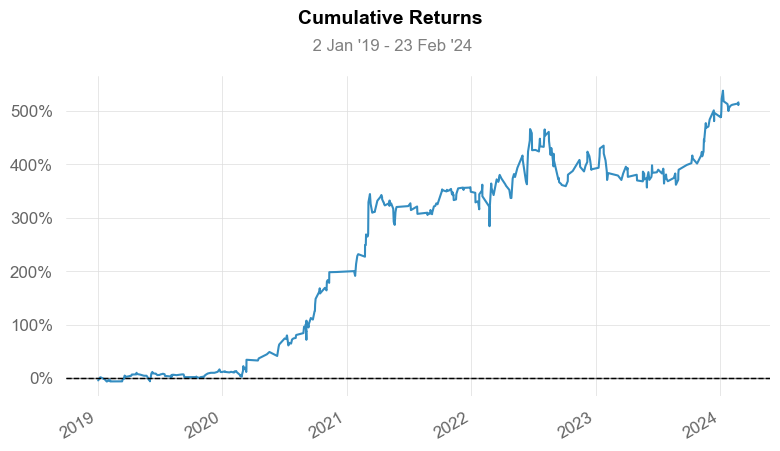

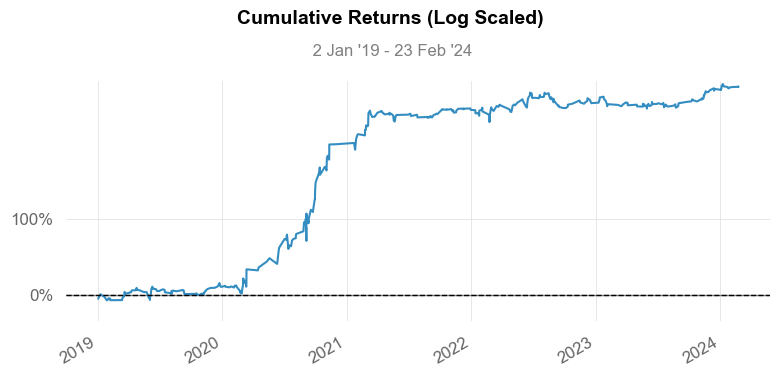

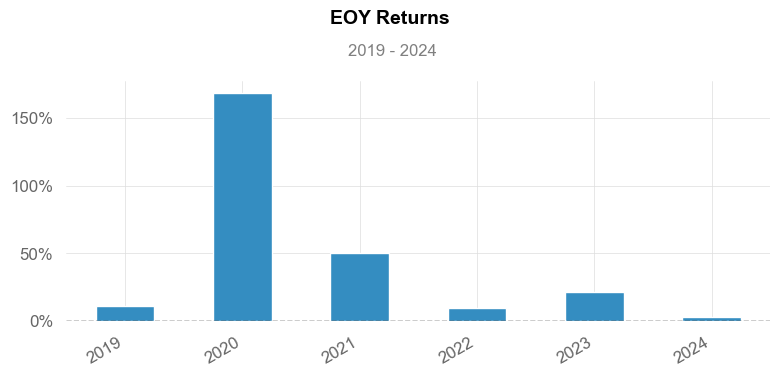

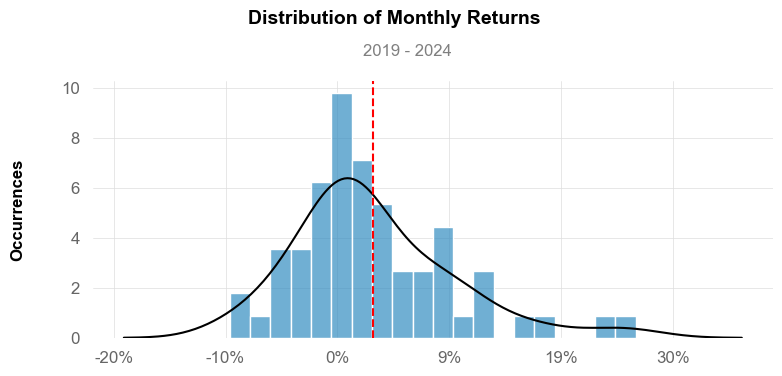

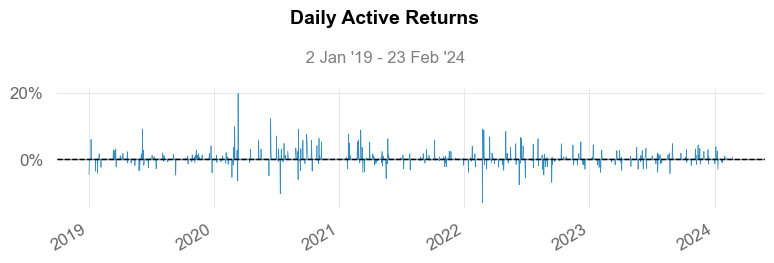

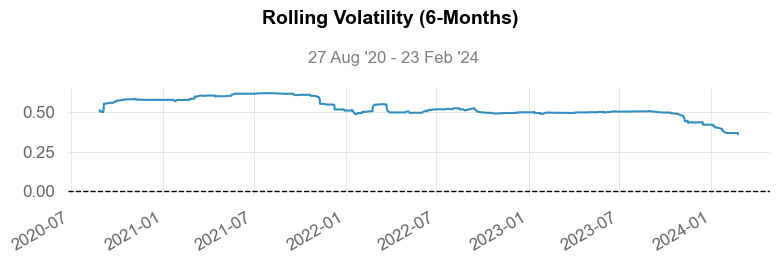

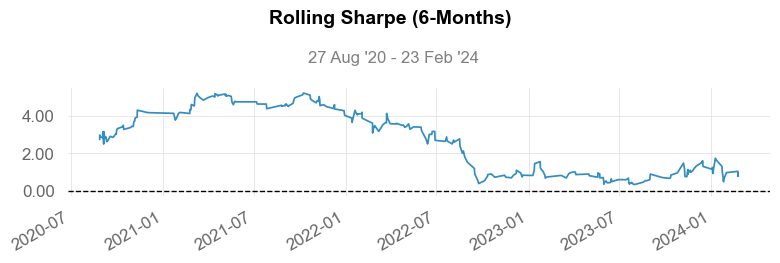

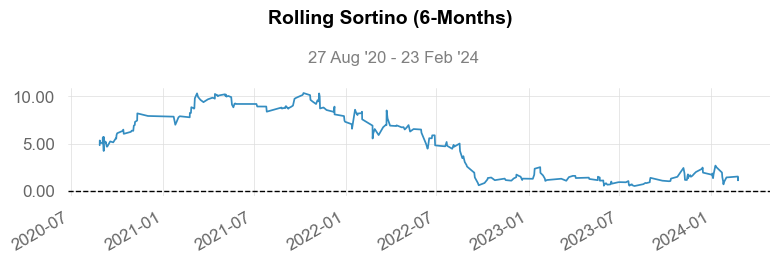

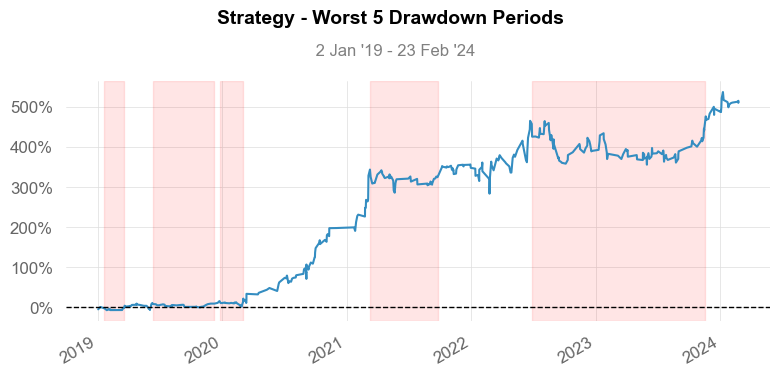

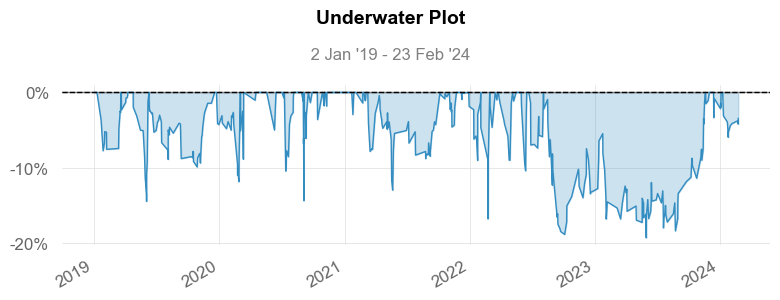

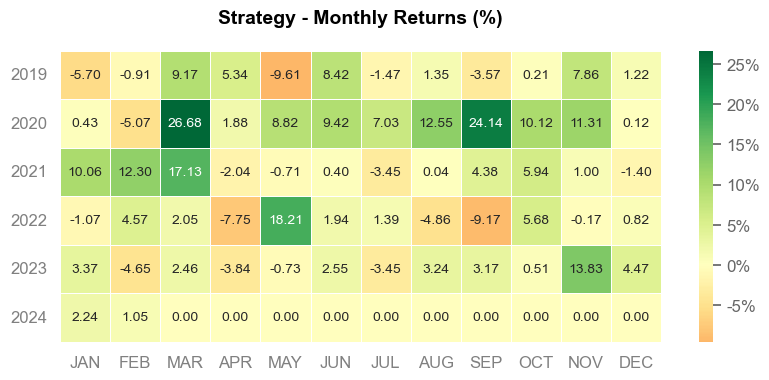

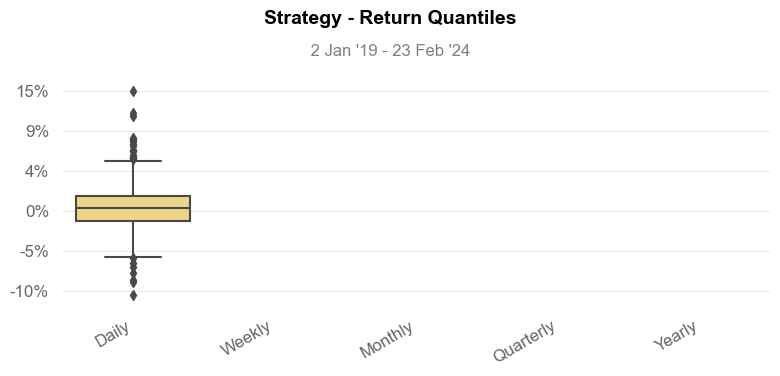

In [318]:
import quantstats as qs
qs.reports.full(ret)

### Walk Forward

In [238]:
start_date = "2000-01-01"
end_date = "2024-03-10"
hp = 100
n_splits = 40
warmup = 30
out=[]

for train_dates, test_dates in tqdm(time_series_cv_dates(n_splits, start_date, end_date, warm_up_splits= warmup)):

    trainStart, trainEnd = pd.to_datetime(train_dates)
    testStart, testEnd = pd.to_datetime(test_dates)
    X_train, X_test, Y_train, Y_test = X_clean.loc[trainStart:trainEnd], X_clean.loc[testStart:testEnd],Y_clean.loc[trainStart:trainEnd], Y_clean.loc[testStart:testEnd]    

    # Modeling
    clf = RandomForestClassifier(criterion ='entropy', min_impurity_decrease=0.0025, min_samples_leaf=50, max_features = None, n_estimators = 100, bootstrap=True, n_jobs =-1) 
    clf = clf.fit(X_train.values, Y_train['bin'], sample_weight=Y_train['ret'].abs())    

    y_test_proba = clf.predict_proba(X_test.values)[:,1]
    temp = Y_test.copy()
    temp['proba'] = y_test_proba
    out.append(temp)

out = pd.concat(out, axis = 0).sort_index()

10it [01:38,  9.80s/it]


In [256]:
trainStart, trainEnd = pd.to_datetime("2000-01-01"), pd.to_datetime("2019-12-30"); trainDays = (trainEnd - trainStart).days/365*250
testStart, testEnd = pd.to_datetime("2022-01-01"), pd.to_datetime("2024-03-01"); testDays = (testEnd - testStart).days/365*250

In [257]:
(out.ret[out.proba>0.55]-1)

Time0
2018-01-29 09:37:40   -0.998178
2018-02-02 10:59:51   -1.000806
2018-02-02 13:58:25   -1.003800
2018-02-04 17:00:33   -1.000670
2018-02-05 10:19:30   -1.004960
                         ...   
2024-02-01 09:59:36   -0.992815
2024-02-21 13:23:52   -0.979616
2024-02-23 03:24:06   -0.997601
2024-02-23 10:04:17   -0.997290
2024-03-04 08:31:50   -0.999099
Name: ret, Length: 528, dtype: float64

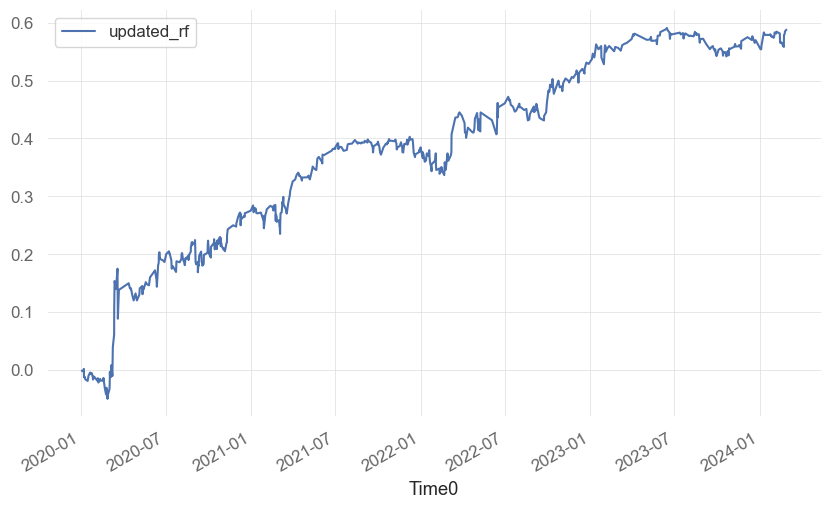

In [304]:
# Benchmark
# np.log(df_ohlcv.Close).diff()[testStart:testEnd].cumsum().plot(label = 'buy and hold')
# Y.ret[testStart:testEnd].cumsum().plot(label = 'sample')
# (Y.ret[testStart:testEnd]-0.0001).cumsum().plot(label = 'sample with commission')
out.ret[out.proba>0.50][testStart:testEnd].cumsum().plot(label='updated_rf')
# Y_test.ret[y_proba_test>0.55][testStart:testEnd].cumsum().plot(label='simple_rf')
plt.legend()
plt.show()

<Axes: xlabel='Time0'>

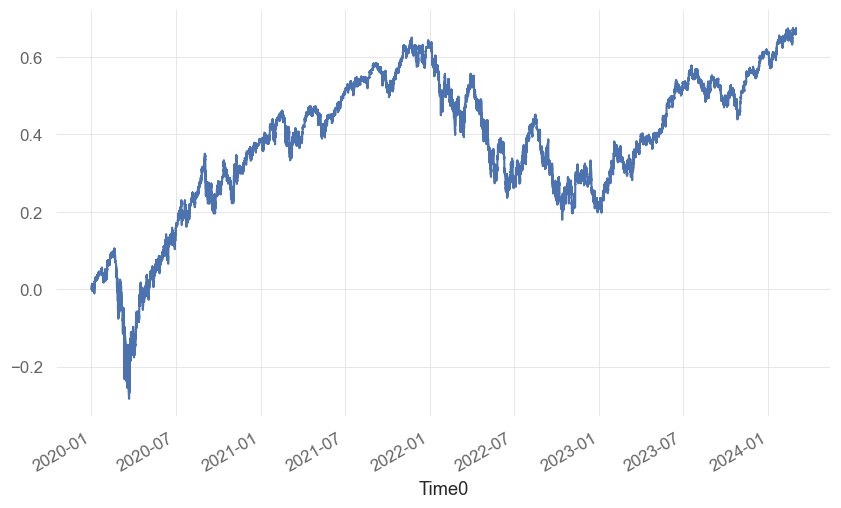

In [303]:
np.log(df.Close)[testStart:testEnd].diff().cumsum().plot()